In [21]:
# import pyade.lshade

import numpy as np
from numba import jit
import time

from mealpy.bio_based import BBO
from mealpy.evolutionary_based.DE import L_SHADE
from mealpy.evolutionary_based.MA import OriginalMA
from mealpy.swarm_based.MSA import OriginalMSA

from mealpy.utils.problem import Problem
# from geomdl import NURBS
# from geomdl import knotvector

#import inspect
from matplotlib import pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

In [423]:
class despline3d:

    def __init__(self, type = "DE-SPLINE", debug=0 ):
        '''
        type = DE-NURBS or DE-SPLINE        
        use set_problem and set_algorithm to customize
        '''   
        self.type = type        

        self.problem_defined = False
        self.algorithm_defined = False
        

        # log variables
        self.log_fit = []
        self.log_time = []
        self.log_path = [] 
        self.debug = debug
        
        # log variables
        self.log_fit = []
        self.log_time = []
        self.log_path = [] 
        
        

    def set_problem(self, problem_params = None):
        ''' Set problem params 
        
        
        
        '''

        if problem_params is None:            
            problem_params = {
            "r": 0.075/2*np.sqrt(2),            
            "pinit":[0.0, 0.0,0.],
            "pgoal":[1., 1.,0.], 
            "vinit":[1., .0,0.], 
            "vgoal":[1., 0.0,0.],
            "obs" : [],             
            "dt" : 0.01, 
            "npoints": 20,             
            "nsplines": 2,
            "lb": [-2, -2, -2, -2, -2, -2],
            "ub": [2, 2, 2, 2, 2, 2],
            "alpha_costfunction" : 0.00125,
            "external_costfunction": None,
            }
        else:
            self.problem_params = problem_params        

        self.r = self.problem_params["r"]
        self.obs = self.problem_params["obs"]
        self.pinit = self.problem_params["pinit"]
        self.pgoal = self.problem_params["pgoal"]
        self.vinit = self.problem_params["vinit"]
        self.vgoal = self.problem_params["vgoal"]
        self.npoints = self.problem_params["npoints"]
        
        self.dt = self.problem_params["dt"]
        self.nsplines = self.problem_params["nsplines"]
        self.alpha = self.problem_params["alpha_costfunction"]

        if problem_params["external_costfunction"] is not None: 
            self.costfunction = problem_params["external_costfunction"]
        elif self.type in "DE-SPLINE":
            self.costfunction = self.costfunction_spline

        self.problem_defined = True
        # self.dt = np.linalg.norm(np.array(self.pinit)-np.array(self.pgoal))/self.npoints
        self.problem_dict = {
            "fit_func": self.costfunction,
            "lb": self.problem_params["lb"],
            "ub": self.problem_params["ub"],
            "minmax": "min",
            "log_to": None,
        }
        
        

    def get_problem_params(self):
        return self.problem_params
    
    def get_algorithm_params(self):
        return self.algorithm_params
    
    def set_algorithm(self,algorithm_params=None):
        '''
        Set algorithm params:
        
        '''     
        if not self.problem_defined:
            print("Problem is not defined.")
            return None
        if algorithm_params is None:            
            algorithm_params = {
                "algorithm": "OriginalMSA",                
                "population_size" : 50,
                "nbest": 5,
                "partition":0.5,
                "max_step_size":1.0,
                # "memory_size" : 3, 
                "max_iterations" : 1000,
                "boundaries" : [],           
            }
        else:
            self.algorithm_params = algorithm_params

        if self.type in "DE-SPLINE":
            self.dim = 3*self.nsplines

        self.algorithm = algorithm_params["algorithm"]

        if self.algorithm in "OriginalMSA":
            self.model = OriginalMSA(epoch=algorithm_params["max_iterations"], pop_size=algorithm_params["population_size"], \
                n_best=algorithm_params["nbest"], partition=algorithm_params["partition"], max_step_size=algorithm_params["max_step_size"])
        elif self.algorithm in "LSHADE":
            self.model = L_SHADE(epoch=algorithm_params["max_iterations"], pop_size=algorithm_params["population_size"], \
                miu_f=algorithm_params["miu_f"], miu_cr=algorithm_params["miu_cr"])
        self.algorithm_defined = True

    def print_params(self) :
        # signature = inspect.signature(self.__init__)
        # for name, parameter in signature.parameters.items():
        #     print(name, parameter.default, parameter.annotation, parameter.kind)
        print(self.type)
        print(self.algorithm_params)
        print(self.problem_params)
    
    @jit(forceobj=True)
    def run(self, repeat_test=1):

        if not self.problem_defined:
            print("Problem is not defined.")
            return None
        if not self.algorithm_defined:
            print("Algorithm is not defined.")
            return None

        self.log_fit  = []
        self.log_time = []
        self.log_path = []
        
        for i in range(repeat_test):
            
            

            start = time.time()
            # We run the algorithm and obtain the results
            # solution, fitness = algorithm.apply(timeT=2,**params)
            solution, fit_value = self.model.solve(self.problem_dict)
            now = time.time()
            time_elapse = now - start 

            best_solution = solution             
            #self.printlog(str(i)  + " - Solution = " + str(best_solution) + str(fit_value))    
            
            self.log_path.append(best_solution)
            self.log_fit.append(fit_value)
            self.log_time.append(time_elapse)
         
            
    def printlog(self, msg):
        if self.debug:
            print(msg)    

        

    def set_obstacles(self, obs):
        self.obs = obs    

    def spline(self, p0, p1, p0l, p1l):
        """ retorna um conjunto de pontos que compõem um spline, componente x: fx e componente y: fy
        """  
        # t = np.linspace(0,1,int(self.npoints/2))#
        t = np.arange(0,1,self.dt)  
        f1 = 2*t**3 -3*t**2 + 1
        f2 = -2*t**3 + 3*t**2
        f3 = t**3 -2*t**2 + t
        f4 = t**3 - t**2    

        fx = p0[0]*f1 + p1[0]*f2 + p0l[0]*f3 + p1l[0]*f4
        fy = p0[1]*f1 + p1[1]*f2 + p0l[1]*f3 + p1l[1]*f4
        fz = p0[2]*f1 + p1[2]*f2 + p0l[2]*f3 + p1l[2]*f4

        return fx, fy, fz

    
    
    @jit(forceobj=True)
    def costfunction_spline(self, parameters):
        """ retorna a função de custo, combinação entre suavidade e comprimento
        parameters deve conter uma lista com 4 elementos"""        

        # define os pontos
        p0 = np.array([self.pinit[0], self.pinit[1], self.pinit[2]])
        p0l = np.array([self.vinit[0], self.vinit[1], self.vinit[2]])
        
        
        

        if np.round(parameters[5]*10,0) >= 2:
            p1 = p2 = np.array([parameters[0], parameters[1], parameters[2]])
            x = np.cos(parameters[3]) * np.cos(parameters[4])
            z = np.sin(parameters[3]) * np.cos(parameters[4])
            y = np.sin(parameters[4])
            p1l = np.array([x,y,z])
            # p1l = np.array([parameters[3], parameters[4], parameters[5]])
            # p1l = p1l/(np.linalg.norm(p1l)+1e-18)
            

            #a = time.time()
            # obtem dois splines
            fx1, fy1, fz1 = self.spline(p0, p1, p0l, p1l)
            p2l = p1l
            p3 = np.array([self.pgoal[0], self.pgoal[1], self.pgoal[2]])
            p3l = np.array([self.vgoal[0], self.vgoal[1], self.vgoal[2]])                
            p3l = p3l/(np.linalg.norm(p3l)+1e-18)
            fx2, fy2, fz2 = self.spline(p2, p3, p2l, p3l)
            #print("curve = ", time.time() - a) 

            # une os splines
            fcx = np.append(fx1,fx2[1:])
            fcy = np.append(fy1,fy2[1:])
            fcz = np.append(fz1,fz2[1:])

            fx = fcx
            fy = fcy
            fz = fcz
        else:
            p1 = np.array([self.pgoal[0], self.pgoal[1], self.pgoal[2]])
            p1l = np.array([self.vgoal[0], self.vgoal[1], self.vgoal[2]])          
            p1l = p1l/(np.linalg.norm(p1l)+1e-18)

            # p1l = np.array([path_params[3], path_params[4], path_params[5]])
            # p1l = p1l/(np.linalg.norm(p1l)+1e-18)
            fx1, fy1, fz1 = self.spline(p0, p1, p0l, p1l)
            fx = fx1
            fy = fy1
            fz = fz1
        # verifica se o caminho está livre de obstáculos
        #a = time.time()
        #penalidade = self.isfree(fcx, fcy)
        penalidade  = 0
        # if max(fx) > 1.5 -self.r  or min(fx) < 0.0 + self.r  or max(fy) > 1.3 -self.r  or min(fy) < 0.0 +self.r :
        #     penalidade += 10e6

        test = [(1/(o[3]+self.r)**2)*(np.array(fx)-o[0])**2 + \
                (1/(o[4]+self.r)**2)*(np.array(fy)-o[1])**2 + \
                (1/(o[5]+self.r)**2)*(np.array(fz)-o[2])**2 for o in self.obs] 
        test = np.array(test)
        penalidade += len(test[test < 1 ])*10e6

        # obtém a suavidade s do caminho e o comprimento total l do caminho
        # s, l = self.smoothness(fcx, fcy)
        #a = time.time()
        
        smoothness = 0
        
        # ai = np.linalg.norm(np.diff(np.array([fx[:-1],fy[:-1]])).T, axis=1)
        # bi = np.linalg.norm(np.diff(np.array([fx[1:],fy[1:]])).T, axis=1) #np.diff(np.array([fx,fy])).T #np.linalg.norm(pt1-pt)
        # pt = np.array([fx[2:],fy[2:]])
        # pt2 = np.array([fx[:-2],fy[:-2]])  
        # ci = np.linalg.norm((pt2-pt).T, axis=1)

        # th = (ai**2 + bi**2 - ci**2)/(2*ai*bi)
        # th = np.clip(th, a_min=-1.0, a_max=1.0)
        # v = np.diff(np.array([fx,fy]))      
        # #print(v.shape, np.linalg.norm(v, axis=0).shape, len((2*(np.pi - np.arccos(th))/(ai + bi))**2))
        # smoothness = np.sum(np.linalg.norm(v[:,1:], axis=0)*(2*(np.pi - np.arccos(th))/(ai + bi))**2)         
        # #smoothness = self.dt*np.sum((2*(np.pi - np.arccos(th))/(ai + bi))**2) 

        # if np.isnan(smoothness):
        #     smoothness = 10e6
        length =  np.sum(np.linalg.norm(np.diff(np.array([fx,fy, fz])).T, axis=1))
        # length =  np.sum(np.linalg.norm(np.diff(np.array([fx1,fy1])).T, axis=1)) + np.sum(np.linalg.norm(np.diff(np.array([fx2,fy2])).T, axis=1))

        f2 = smoothness
        f1 = length        

        return self.alpha*f2 + f1 + penalidade



    def get_curve_points(self, path_params, problem_params):
        """
        input: path_params, problem_params
        return: fx, fy (curve points x, y)
        """
        
        pinit = problem_params["pinit"]
        pgoal = problem_params["pgoal"]
        vinit = problem_params["vinit"]
        vgoal = problem_params["vgoal"]
        npoints = problem_params["npoints"]
        dt = problem_params["dt"]
        # dt = np.linalg.norm(np.array(pinit)-np.array(pgoal))/npoints
        
        
        # problem_params["dt"] =  dt
        if self.type in "DE-SPLINE":            
            # Define the points of the curve  
            #  
            p0 = np.array([self.pinit[0], self.pinit[1], self.pinit[2]])
            p0l = np.array([self.vinit[0], self.vinit[1], self.vinit[2]])
            

            

            if np.round(path_params[5]*10,0) >= 2:
                p1 = p2 = np.array([path_params[0], path_params[1], path_params[2]])
                x = np.cos(path_params[3]) * np.cos(path_params[4])
                z = np.sin(path_params[3]) * np.cos(path_params[4])
                y = np.sin(path_params[4])
                p1l = np.array([x,y,z])

                # p1l = np.array([path_params[3], path_params[4], path_params[5]])
                # p1l = p1l/(np.linalg.norm(p1l)+1e-18)
                fx1, fy1, fz1 = self.spline(p0, p1, p0l, p1l)
                print("2 x spline")
                p2l = p1l
                p3 = np.array([self.pgoal[0], self.pgoal[1], self.pgoal[2]])
                p3l = np.array([self.vgoal[0], self.vgoal[1], self.vgoal[2]])          
                p3l = p3l/(np.linalg.norm(p3l)+1e-18)
                
                fx2, fy2, fz2 = self.spline(p2, p3, p2l, p3l)
                #print("curve = ", time.time() - a) 

                # une os splines
                fcx = np.append(fx1,fx2[1:])
                fcy = np.append(fy1,fy2[1:])
                fcz = np.append(fz1,fz2[1:])

                fx = fcx
                fy = fcy
                fz = fcz
            else:
                
                print("1 x spline")
                p1 = np.array([self.pgoal[0], self.pgoal[1], self.pgoal[2]])
                p1l = np.array([self.vgoal[0], self.vgoal[1], self.vgoal[2]])          
                p1l = p1l/(np.linalg.norm(p1l)+1e-18)

                # p1l = np.array([path_params[3], path_params[4], path_params[5]])
                # p1l = p1l/(np.linalg.norm(p1l)+1e-18)
                fx1, fy1, fz1 = self.spline(p0, p1, p0l, p1l)
                fx = fx1
                fy = fy1
                fz = fz1

            
        return fx, fy, fz

     

In [424]:
def plot_ellipsoid(center=(0,0,0), dimensions=(0.1,0.1,0.1), ax=None, Npoints=100, color='red', alpha=0.2):

        u = np.linspace(0.0, 2.0 * np.pi, Npoints)
        v = np.linspace(0.0, np.pi, Npoints)
        z = center[2] + dimensions[2]*np.outer(np.cos(u), np.sin(v))
        y = center[1] + dimensions[1]*np.outer(np.sin(u), np.sin(v))
        x = center[0] + dimensions[0]*np.outer(np.ones_like(u), np.cos(v))

        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
        ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color=color, alpha=alpha)
        
        return ax

In [425]:
# get the planner
planner_spline = despline3d(type="DE-SPLINE", debug=0)

# set problem params and use default alorithm params

problem_params = {
            "r": 0.1,            
            "pinit":[-1.0, .0,0.],
            "pgoal":[1., 0.,1.], 
            "vinit":[1., .0,0.], 
            "vgoal":[0., -1.0,0.],
            # "obs" : [],        
            "obs" : [[-0.5, -0.005, 0.18, 0.2, 0.2, 0.2], [0.5, 0.10, 0.6, 0.3, 0.4,0.4]],                
            "dt" : 0.01, 
            "npoints": 20,             
            "nsplines": 2,
            "lb": [-1, -1, -1, -np.pi, -np.pi, 0.1],
            "ub": [1, 1, 1, np.pi, np.pi, 0.3],
            "alpha_costfunction" : 0.00125,
            "external_costfunction": None,
            }
planner_spline.set_problem(problem_params)

algorithm_params = {
                "algorithm": "OriginalMSA",                
                "population_size" : 100,
                "nbest": 5,
                "partition":0.5,
                "max_step_size":0.1,
                "max_iterations" : 1000,                         
            }
algorithm_params = {
                "algorithm": "LSHADE",                
                "population_size" : 50,
                "miu_cr": 0.5,
                "miu_f":0.5,                
                "max_iterations" : 1000,                
            }

            
planner_spline.set_algorithm(algorithm_params)

In [426]:
planner_spline.run()

In [427]:
print("Time = ", planner_spline.log_time[0])
print("Costfunction value = ", planner_spline.log_fit[0])   
print("Costfunction value = ", planner_spline.log_path[0])   
np.linalg.norm(np.array(problem_params["pinit"]) - np.array(problem_params["pgoal"]))

Time =  10.23210597038269
Costfunction value =  2.8806418902566544
Costfunction value =  [-0.35119812  0.62835333  0.879893    0.50380478 -0.00684294  0.24277621]


2.23606797749979

2 x spline


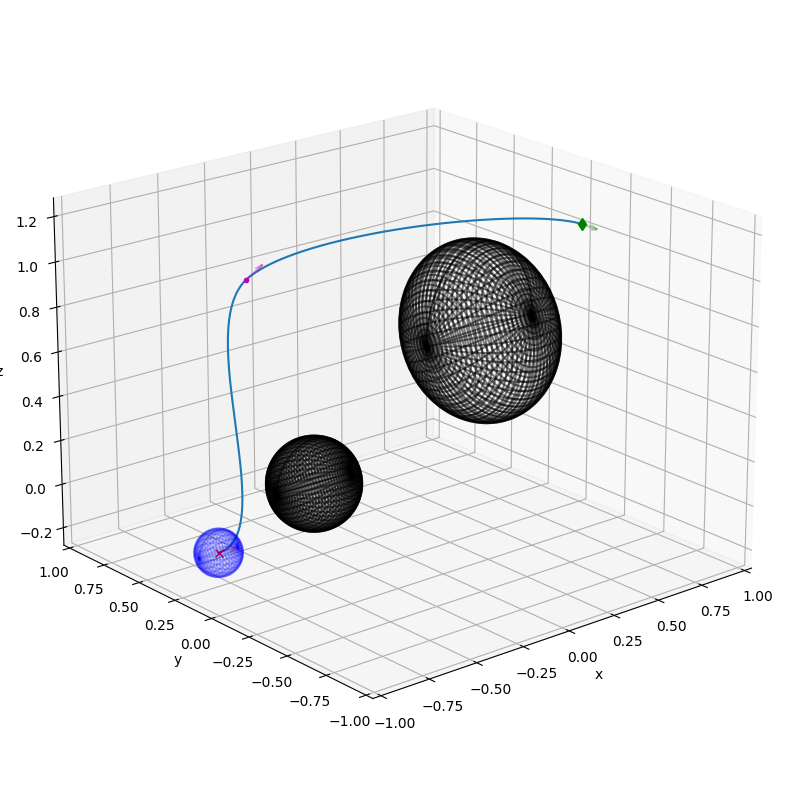

In [428]:
fx, fy, fz = planner_spline.get_curve_points(path_params=planner_spline.log_path[0], problem_params=problem_params)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,  projection='3d')
ax.plot(fx, fy, fz, '-')  
ax.plot(fx[0], fy[0], fz[0], 'xr')  
ax.quiver(fx[0], fy[0], fz[0], problem_params["vinit"][0], problem_params["vinit"][1], problem_params["vinit"][2], arrow_length_ratio=0.4, alpha=0.3,  length=.1, normalize=True, color='red')

ax.plot(fx[-1], fy[-1], fz[-1], 'dg')  
ax.quiver(fx[-1], fy[-1], fz[-1], problem_params["vgoal"][0], problem_params["vgoal"][1], problem_params["vgoal"][2], arrow_length_ratio=0.4, alpha=0.3,  length=.1, normalize=True, color='green')

ax.plot(planner_spline.log_path[0][0],planner_spline.log_path[0][1],planner_spline.log_path[0][2], '.m')  

vx = np.cos(planner_spline.log_path[0][3]) * np.cos(planner_spline.log_path[0][4])
vz = np.sin(planner_spline.log_path[0][3]) * np.cos(planner_spline.log_path[0][4])
vy = np.sin(planner_spline.log_path[0][4])

ax.quiver(planner_spline.log_path[0][0],planner_spline.log_path[0][1],planner_spline.log_path[0][2], vx, vy, vz, arrow_length_ratio=0.4, alpha=0.3,  length=.1, normalize=True, color='m')


for obi in problem_params["obs"]: 
    ax = plot_ellipsoid(center=(obi[0], obi[1], obi[2]), dimensions=(obi[3], obi[4], obi[5]), ax=ax, color= 'black', alpha=0.5,Npoints=200)
    
ax = plot_ellipsoid(center=(fx[0], fy[0], fz[0]), dimensions=( problem_params["r"],  problem_params["r"],  problem_params["r"]), ax=ax, color= 'blue')    

ax.view_init(20,-130)
l = [-1, 1, -1, 1, -0, 1]
ax.set_xlim(l[0],l[1])
ax.set_ylim(l[2],l[3])
ax.set_zlim(l[4],l[5])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_aspect('equal')

In [268]:
np.sum(np.linalg.norm(np.diff(np.array([fx,fy, fz])).T, axis=1))

1.4825870110590667

In [422]:
test = [(1/(o[3]+0.1)**2)*(np.array(fx)-o[0])**2 + (1/(o[4]+0.1)**2)*(np.array(fy)-o[1])**2 + (1/(o[4]+0.1)**2)*(np.array(fy)-o[1])**2 - (1/(o[5]+0.1)**2)*((o[2]+0.1))**2 for o in problem_params["obs"]] 
test = np.array(test)
len(test[test < 1 ])

48

In [421]:
test

array([[ 1.90722222,  1.8004341 ,  1.70197779,  1.61142772,  1.52841653,
         1.45263174,  1.38381252,  1.32174658,  1.26626701,  1.21724926,
         1.17460821,  1.13829522,  1.10829532,  1.08462442,  1.06732665,
         1.05647164,  1.05215204,  1.05448094,  1.06358947,  1.07962438,
         1.1027458 ,  1.13312491,  1.17094183,  1.21638347,  1.26964148,
         1.33091029,  1.40038518,  1.47826043,  1.56472754,  1.65997348,
         1.76417909,  1.87751744,  2.00015237,  2.13223694,  2.27391212,
         2.42530545,  2.58652974,  2.75768192,  2.93884188,  3.13007143,
         3.33141331,  3.54289022,  3.76450398,  3.99623473,  4.23804021,
         4.48985505,  4.75159021,  5.02313241,  5.30434368,  5.59506096,
         5.89509572,  6.20423374,  6.52223484,  6.84883281,  7.18373527,
         7.52662369,  7.87715343,  8.23495387,  8.59962858,  8.9707556 ,
         9.34788772,  9.7305529 , 10.11825469, 10.51047276, 10.90666344,
        11.30626045, 11.70867552, 12.11329922, 12.5